<a href="https://colab.research.google.com/github/kvikik/MMO/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 5.2

По итоговому датасету:

1. Преобразовать текстовые данные (очистка + токенизация + нормализация).
2. Обучить модель **Word2Vec** на текстах.
3. Заполнить пропуски в числовых признаках через **SimpleImputer**.
4. Выбрать алгоритм **кластеризации** и построить кластеры.
5. Построить модель для **предсказания кластера** (supervised) с подбором гиперпараметров через **GridSearchCV**.


In [23]:
!pip install pymorphy3 gensim scikit-learn nltk # бибилотеки с которыми будем работать

In [24]:
# Базовые импорты
import pandas as pd
import numpy as np
import sqlite3

In [43]:
# Подключаемся к базе и читаем таблицу articles
DB_FILE = "articles.sqlite"

conn = sqlite3.connect(DB_FILE)
df = pd.read_sql_query("SELECT * FROM articles;", conn)
conn.close()

In [6]:
df.head()

,guid,title,description,url,published_at,comments_count,created_at_utc,rating
0,fd3a51d1-5cee-4ec2-b53f-effbf1ab74bd,В России вырос МРОТ,Реклама Фото: Александр Сухов / РИА Новости С ...,https://lenta.ru/news/2025/01/01/v-rossii-vyro...,2025-01-01T00:15:00,None,2026-01-18T01:43:00.417204+00:00,None
1,42533e64-a04e-4ce5-8358-b2104dc5f0b2,Миллионы россиян смотрят в Новый год одни и те...,Реклама Фото: pics five / Shutterstock / Fotod...,https://lenta.ru/news/2025/01/01/films/,2025-01-01T00:02:00,None,2026-01-18T01:43:00.548670+00:00,None
2,1d82cea3-8766-4dc4-86b5-008bc9bba49b,Работающим пенсионерам проиндексировали пенсии,Реклама Фото: Elena Mayorova / Globallookpress...,https://lenta.ru/news/2025/01/01/rabotayuschim...,2025-01-01T00:30:00,None,2026-01-18T01:43:00.686638+00:00,None
3,49433220-b1c9-4360-9fb9-c639c4320dcc,В России стало дороже развестись,Реклама Фото: Hutomo Abrianto / Unsplash В Рос...,https://lenta.ru/news/2025/01/01/v-rossii-stal...,2025-01-01T00:02:00,None,2026-01-18T01:43:00.835005+00:00,None
4,7ff041d5-99aa-472b-ac63-be8a74c2afb7,Пенсии россиян проиндексируют,Реклама Фото: Maksim Konstantinov / Global Loo...,https://lenta.ru/news/2025/01/01/pensii-rossiy...,2025-01-01T00:34:00,None,2026-01-18T01:43:00.970848+00:00,None


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9325 entries, 0 to 9324
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   guid            9325 non-null   object
 1   title           9325 non-null   object
 2   description     9325 non-null   object
 3   url             9325 non-null   object
 4   published_at    9325 non-null   object
 5   comments_count  0 non-null      object
 6   created_at_utc  9325 non-null   object
 7   rating          0 non-null      object
dtypes: object(8)
memory usage: 582.9+ KB


## Предобработка

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer

In [12]:
#nltk.download("stopwords")

In [52]:
STOP_RU = set(stopwords.words("russian"))
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)
morph = MorphAnalyzer()

def preprocess_text(text: str):
    # 1. Приведение к строке и нижнему регистру
    text = str(text).lower()
    # 2. Токенизация по буквенным токенам
    tokens = TOKEN_RE.findall(text)
    # 3. Удаление стоп-слов и коротких токенов
    tokens = [t for t in tokens if t not in STOP_RU and len(t) > 2]
    # 4. Лемматизация
    lemmas = [morph.parse(t)[0].normal_form for t in tokens]
    return lemmas

    return clean_tokens


In [53]:
text_col = "description"
tokenized_texts = df[text_col].astype(str).apply(preprocess_text).tolist()
len(tokenized_texts)

9325

In [54]:
df[['description', 'clean_text']].head()


,description,clean_text
0,Реклама Фото: Александр Сухов / РИА Новости С ...,"[реклама, фото, александр, сухов, риа, новость..."
1,Реклама Фото: pics five / Shutterstock / Fotod...,"[реклама, фото, pics, five, shutterstock, foto..."
2,Реклама Фото: Elena Mayorova / Globallookpress...,"[реклама, фото, elena, mayorova, globallookpre..."
3,Реклама Фото: Hutomo Abrianto / Unsplash В Рос...,"[реклама, фото, hutomo, abrianto, unsplash, ро..."
4,Реклама Фото: Maksim Konstantinov / Global Loo...,"[реклама, фото, maksim, konstantinov, global, ..."


## Обучение модели

Числовых признаков как таковых нет, поэтому логично делать и кластеризацию, и дальнейшее обучение только по текстовым векторам Word2Vec


In [55]:
from gensim.models import Word2Vec

w2v = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,
    epochs=10,
)

def doc_vector(tokens, model):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

doc_vectors = np.vstack([doc_vector(t, w2v) for t in tokenized_texts])
doc_vectors.shape


(9325, 100)

In [56]:
X_features = doc_vectors
X_features.shape

(9325, 100)

## Обработка числовых признаков

Числовые признаки (comments_count, rating) записаны в качетсве None и не несут информации. В качестве признаков используем только векторы текста.

## Кластеризация


 Выбираем кластеризацию KMeans.
 Почему KMeans:

* Работает с числовыми признаками фиксированной размерности, как вектора Word2Vec.

* Даёт хорошо интерпретируемые кластеры через центроиды (можно анализировать «среднюю» статью кластера).

* Быстро обучается и легко подбирать количество кластеров через метрики (например, силуэт).

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [62]:
# Перебираем количество кластеров от 2 до 10
for k in range(2, 11):
    # инициализируем модель KMeans с k кластерами
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    # обучаем модель и получаем метки кластеров для всех объектов
    labels = km.fit_predict(X_features)
    # считаем коэффициент силуэта для текущего разбиения на кластеры
    sil = silhouette_score(X_features, labels)
    # сохраняем значение силуэта в словарь для этого k
    sil_scores[k] = sil
    # выводим k и соответствующее ему значение силуэта
    print(f"k={k}, silhouette={sil:.4f}")

# находим k, для которого значение силуэта максимальное
best_k = max(sil_scores, key=sil_scores.get)

print("Лучшее k по силуэту:", best_k)

k=2, silhouette=0.1304
k=3, silhouette=0.1778
k=4, silhouette=0.1907
k=5, silhouette=0.1728
k=6, silhouette=0.1666
k=7, silhouette=0.1790
k=8, silhouette=0.1711
k=9, silhouette=0.1792
k=10, silhouette=0.1371
Лучшее k по силуэту: 4


Получился KMeans с оптимальным числом кластеров k=4 по метрике силуэта.

Выбор числа кластеров
* Для k от 2 до 10 коэффициент силуэта менялся примерно от 0.13 до 0.18.
* Максимальное значение силуэта наблюдается при
k=4, поэтому именно это количество кластеров выбрано как оптимальное.


In [60]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_features)
df["cluster"] = cluster_labels
df["cluster"].value_counts()


,count
cluster,
1,3671
3,3494
2,1920
0,240


Два крупных кластера (1 и 3) описывают основные тематики статей, один средний (2) отражает менее частую тематику, а небольшой кластер 0 соответствует узкой группе уникальных документов.


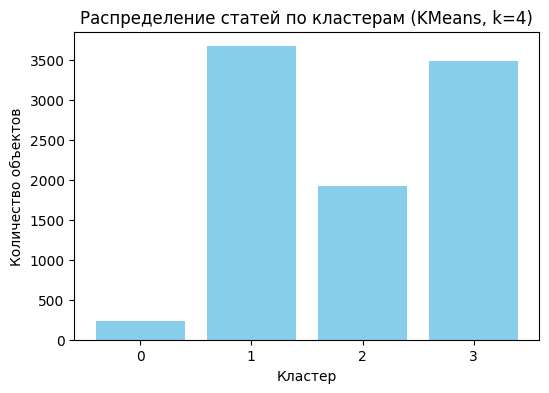

In [64]:
import matplotlib.pyplot as plt

cluster_counts = df["cluster"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(cluster_counts.index, cluster_counts.values, color="skyblue")
plt.xlabel("Кластер")
plt.ylabel("Количество объектов")
plt.title("Распределение статей по кластерам (KMeans, k=4)")
plt.xticks(cluster_counts.index)
plt.show()


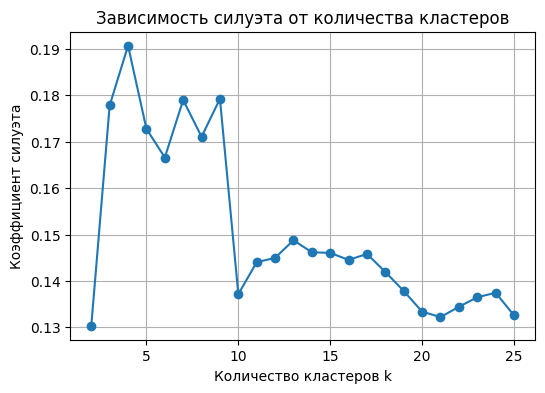

In [65]:
plt.figure(figsize=(6, 4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker="o")
plt.xlabel("Количество кластеров k")
plt.ylabel("Коэффициент силуэта")
plt.title("Зависимость силуэта от количества кластеров")
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


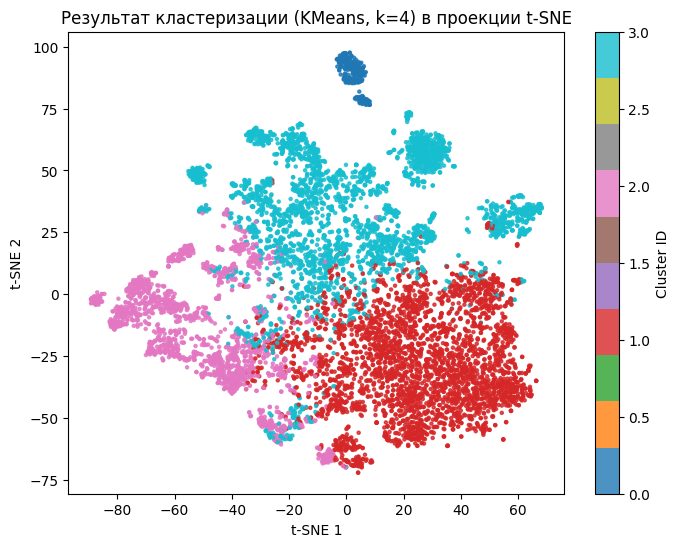

In [67]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = X_features
y = df["cluster"].values  # метки кластеров KMeans

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)

X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=y,
    cmap="tab10",
    s=5,
    alpha=0.8
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Результат кластеризации (KMeans, k=4) в проекции t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


* Для визуализации векторов Word2Vec использована двумерная проекция t-SNE, а цвет точек показывает номер кластера, присвоенный алгоритмом KMeans.

* Красный и бирюзовый кластеры образуют две крупные плотные группы, что говорит о наличии двух основных тематических «массивов» статей в датасете.

* Розовый кластер занимает отдельную область слева и снизу, а синий расположен сверху и слегка отделён от остальных, что указывает на более специфичные тематики новостей.

## Предсказать кластеры методом DecisionTree

In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

X = X_features
y = df["cluster"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "criterion": ["gini", "entropy"],
}

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
)

grid_dt.fit(X_train, y_train)

print("Лучшие параметры:", grid_dt.best_params_)
print("Лучший CV accuracy:", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Лучшие параметры: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Лучший CV accuracy: 0.9066954022988506
Test accuracy: 0.9228020014295926
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       0.93      0.93      0.93      1102
           2       0.90      0.89      0.90       576
           3       0.91      0.93      0.92      1048

    accuracy                           0.92      2798
   macro avg       0.94      0.94      0.94      2798
weighted avg       0.92      0.92      0.92      2798



Модель DecisionTree очень хорошо научилась предсказывать кластеры, ошибается редко.

Качество в целом
* Лучшая найденная модель даёт CV-точность около 0.91, а на тесте точность около 0.92, то есть примерно 92% статей относятся к «правильному» кластеру.

* Средние значения precision/recall/f1-score по всем кластерам тоже около 0.94, что говорит о стабильном качестве для разных групп.

По отдельным кластерам
* Кластер 0: модель попала во все 72 примера без ошибок (precision = 1.00, recall = 1.00).

* Кластеры 1, 2 и 3 тоже предсказываются хорошо: precision и recall около 0.90–0.93, то есть лишь малая часть статей попадает не в свой кластер.

## Предсказать кластеры методом KNN

In [68]:
from sklearn.neighbors import KNeighborsClassifier

X = X_features
y = df["cluster"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

knn = KNeighborsClassifier()

param_grid = {
    "n_neighbors": [3, 5, 10, 15],
    "weights": ["uniform", "distance"],
    "metric": ["cosine"],
}

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший CV accuracy:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Лучшие параметры: {'metric': 'cosine', 'n_neighbors': 10, 'weights': 'distance'}
Лучший CV accuracy: 0.9526581868379536
Test accuracy: 0.9571122230164403
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       0.96      0.96      0.96      1102
           2       0.91      0.98      0.95       576
           3       0.98      0.93      0.95      1048

    accuracy                           0.96      2798
   macro avg       0.96      0.97      0.97      2798
weighted avg       0.96      0.96      0.96      2798



Модель KNN предсказывает кластеры очень точно: точность на кросс‑валидации около 0.95, а на тесте — около 0.96, то есть примерно 96 из 100 статей попадают в свой кластер правильно.

По всем кластерам значения precision, recall и f1-score близки к 1.0, значит:

* Модель почти не перепутывает статьи между кластерами.

* Каждый кластер распознаётся стабильно, без сильного перекоса в пользу какого‑то одного кластера.